In [1]:
cd scripts/

/Users/anil/Code/facebook/scripts


In [6]:
import numpy as np
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from sklearn.cross_validation import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

In [35]:
def transform_x(X, x_transformer = None):
    """
    X = [[x, y, a, t]]
    """
    fw = [500., 1000., 4., 3., 2., 10., 10.]
    minute_v = X[:, 3]%60
    hour_v = X[:, 3]//60
    weekday_v = hour_v//24
    month_v = weekday_v//30
    year_v = (weekday_v//365 + 1)*fw[5]
    hour_v = ((hour_v%24 + 1) + minute_v/60.0)*fw[2]
    weekday_v = (weekday_v%7 + 1)*fw[3]
    month_v = (month_v%12 +1)*fw[4]
    accuracy_v = np.log10(X[:, 2])*fw[6]
    x_v = X[:, 0]*fw[0]
    y_v = X[:, 1]*fw[1]
    return np.hstack((x_v.reshape(-1, 1),\
                     y_v.reshape(-1, 1),\
                     accuracy_v.reshape(-1, 1),\
                     hour_v.reshape(-1, 1),\
                     weekday_v.reshape(-1, 1),\
                     month_v.reshape(-1, 1),\
                     year_v.reshape(-1, 1)))

def transform_y(y, y_transformer = None):
    """
    place_ids to encoded array
    """
    y = y.astype(int)
    if y_transformer == None:
        label_encoder = LabelEncoder()
        label_encoder.fit(y)
        y_transformer = {'encoder': label_encoder}
    new_y = y_transformer['encoder'].transform(y).reshape(-1, 1)
    return (new_y, y_transformer)

def map3eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,4)]
    metric = 0.
    for i in range(3):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@3', metric

def load_data(m, n):
    return np.loadtxt('../grid1_400_100_50_10/grid_data_' + str(m)  + '_' + str(n) + '.csv', delimiter = ',')

def get_preds(probs, encoder):
    return encoder.inverse_transform(np.argsort(probs, axis = 1)[:, ::-1][:, :3])


In [7]:
m, n = 12, 40
data = load_data(m, n)

M = pickle.load(open('../grid1_400_100_50_10/cardinality_pickle.pkl', 'rb'))

train, test = train_test_split(data, test_size = 0.02)

In [81]:
mask = np.array(map(lambda x: M[m][n][x] > 20, train[:, 5]))
card_train = train[mask, :]
print card_train.shape, "card_train_shape"
print train.shape, "train_shape"
print test.shape, "test_shape"

X = transform_x(card_train[:, (1, 2, 3, 4)])
y_orig, enc = transform_y(data[:, 5])
y, enc = transform_y(card_train[:, 5], enc)
test_X = transform_x(test[:, (1, 2, 3, 4)])
test_y, enc = transform_y(test[:, 5], enc)
print X.shape, "X shape"
print y.shape, "y shape"
print test_X.shape, "test_X shape"
print test_y.shape, "test_y shape"
print len(enc['encoder'].classes_)

dtrain = xgb.DMatrix(X, label=np.ravel(y))
dtest = xgb.DMatrix(test_X, label=np.ravel(test_y))

(14359, 6) card_train_shape
(16178, 6) train_shape
(331, 6) test_shape
(14359, 7) X shape
(14359, 1) y shape
(331, 7) test_X shape
(331, 1) test_y shape
770


In [10]:
watchlist = [ (dtrain,'train'), (dtest, 'test') ]

{'num_class': 770, 'silent': 0, 'eval_metric': ['merror', 'mlogloss'], 'nthread': 4, 'eta': 0.1, 'objective': 'multi:softprob', 'max_depth': 6} params


[0]	train-merror:0.532419	train-mlogloss:4.05949	test-merror:0.549849	test-mlogloss:4.52968
[1]	train-merror:0.519744	train-mlogloss:2.75346	test-merror:0.546828	test-mlogloss:3.45458
[2]	train-merror:0.501288	train-mlogloss:2.41366	test-merror:0.534743	test-mlogloss:3.22705
[3]	train-merror:0.490285	train-mlogloss:2.19043	test-merror:0.519637	test-mlogloss:3.09013
[4]	train-merror:0.475451	train-mlogloss:2.01516	test-merror:0.510574	test-mlogloss:2.97837


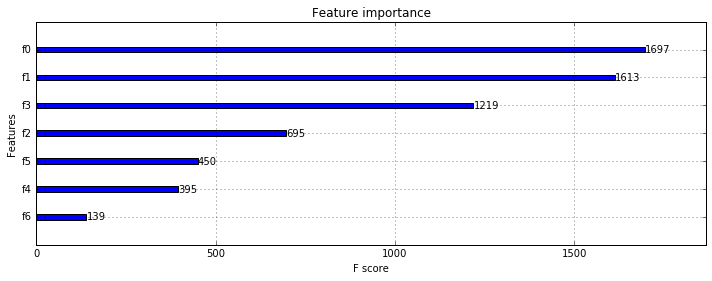

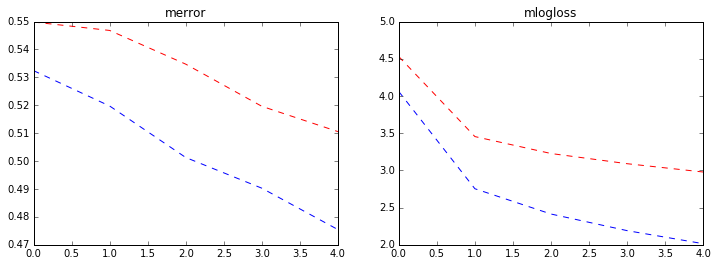

In [46]:
er = {}
bst = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'eval_metric': ['merror', 'mlogloss'],
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 6}, 
                dtrain, 
                num_boost_round = 5,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er)

xgb.plot_importance(bst)
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(er['test']['merror'], 'r--', er['train']['merror'], 'b--')
plt.title("merror")
plt.subplot(1, 2, 2)
plt.title("mlogloss")
plt.plot(er['test']['mlogloss'], 'r--', er['train']['mlogloss'], 'b--')

In [36]:
preds = get_preds(bst.predict(dtest), enc['encoder'])

[0]	train-MAP@3:0.595515	test-MAP@3:0.546828
[1]	train-MAP@3:0.607563	test-MAP@3:0.543807
[2]	train-MAP@3:0.63556	test-MAP@3:0.564955
[3]	train-MAP@3:0.65109	test-MAP@3:0.58006
[4]	train-MAP@3:0.666899	test-MAP@3:0.589124


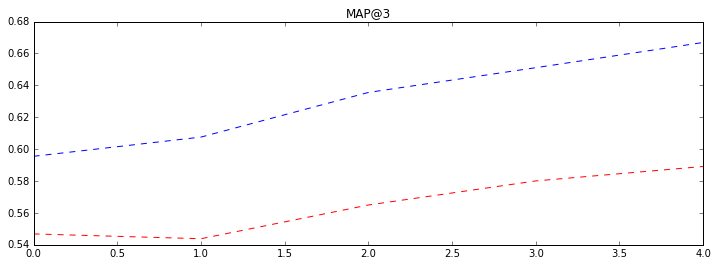

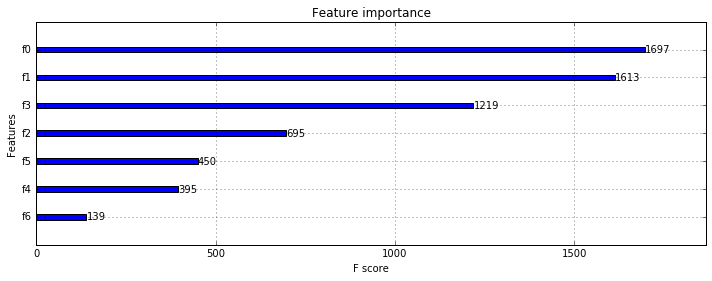

In [54]:
# map3eval as evaluation function
er1 = {}
bst1 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 6}, 
                dtrain, 
                num_boost_round = 5,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er1,
                feval = map3eval,)

plt.figure()
plt.plot(er1['test']['MAP@3'], 'r--', er1['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst1)

Notes: Not much difference when I change the feval function from merror, mlogloss to map3eval. Its just useful in seeing how well our model is doing
based on the evaluation metric. Probably a better objective function that is specific our problem exists? if its not softmax:prob what is it?

[0]	train-MAP@3:0.595515	test-MAP@3:0.546828
[1]	train-MAP@3:0.626506	test-MAP@3:0.555891
[2]	train-MAP@3:0.653458	test-MAP@3:0.574018
[3]	train-MAP@3:0.67052	test-MAP@3:0.586103
[4]	train-MAP@3:0.682986	test-MAP@3:0.592145
[5]	train-MAP@3:0.696706	test-MAP@3:0.601208
[6]	train-MAP@3:0.705133	test-MAP@3:0.607251
[7]	train-MAP@3:0.714952	test-MAP@3:0.607251
[8]	train-MAP@3:0.722334	test-MAP@3:0.613293
[9]	train-MAP@3:0.727418	test-MAP@3:0.622356
[10]	train-MAP@3:0.733686	test-MAP@3:0.628399
[11]	train-MAP@3:0.737517	test-MAP@3:0.625378
[12]	train-MAP@3:0.741834	test-MAP@3:0.634441
[13]	train-MAP@3:0.745804	test-MAP@3:0.637462
[14]	train-MAP@3:0.749147	test-MAP@3:0.640483
[15]	train-MAP@3:0.752211	test-MAP@3:0.640483
[16]	train-MAP@3:0.755206	test-MAP@3:0.643505
[17]	train-MAP@3:0.757852	test-MAP@3:0.646526
[18]	train-MAP@3:0.759942	test-MAP@3:0.649547
[19]	train-MAP@3:0.762518	test-MAP@3:0.649547
[20]	train-MAP@3:0.764399	test-MAP@3:0.649547
[21]	train-MAP@3:0.766558	test-MAP@3:0.649547

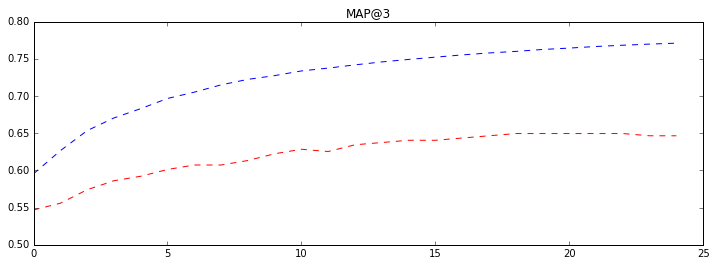

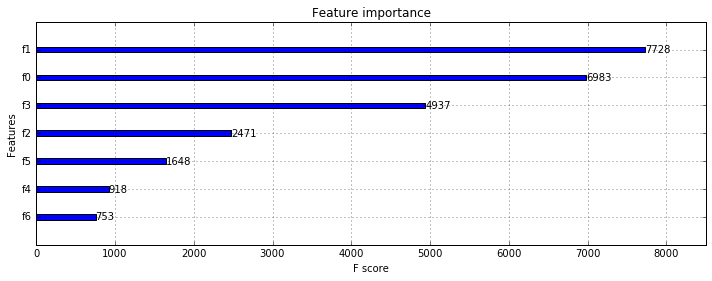

In [55]:
# lower learning rate and more iterations
er2 = {}
bst2 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.01,
                 'objective': 'multi:softprob',
                 'max_depth': 6}, 
                dtrain, 
                num_boost_round = 25,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er2,
                feval = map3eval, maximize = True)

plt.figure()
plt.plot(er2['test']['MAP@3'], 'r--', er2['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst2)

[0]	train-MAP@3:0.595515	test-MAP@3:0.546828
[1]	train-MAP@3:0.627481	test-MAP@3:0.558912
[2]	train-MAP@3:0.653667	test-MAP@3:0.574018
[3]	train-MAP@3:0.671147	test-MAP@3:0.586103
[4]	train-MAP@3:0.68417	test-MAP@3:0.595166
[5]	train-MAP@3:0.69782	test-MAP@3:0.607251
[6]	train-MAP@3:0.707083	test-MAP@3:0.610272
[7]	train-MAP@3:0.71739	test-MAP@3:0.613293
[8]	train-MAP@3:0.724563	test-MAP@3:0.619335
[9]	train-MAP@3:0.7309	test-MAP@3:0.625378
[10]	train-MAP@3:0.737029	test-MAP@3:0.63142
[11]	train-MAP@3:0.740929	test-MAP@3:0.628399
[12]	train-MAP@3:0.746292	test-MAP@3:0.637462
[13]	train-MAP@3:0.75054	test-MAP@3:0.640483
[14]	train-MAP@3:0.754092	test-MAP@3:0.643505
[15]	train-MAP@3:0.757713	test-MAP@3:0.646526
[16]	train-MAP@3:0.761474	test-MAP@3:0.646526
[17]	train-MAP@3:0.76405	test-MAP@3:0.649547
[18]	train-MAP@3:0.766975	test-MAP@3:0.646526
[19]	train-MAP@3:0.769552	test-MAP@3:0.649547
[20]	train-MAP@3:0.772756	test-MAP@3:0.649547
[21]	train-MAP@3:0.774288	test-MAP@3:0.649547
[22]	t

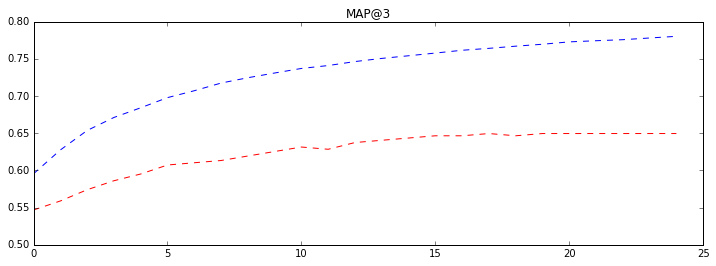

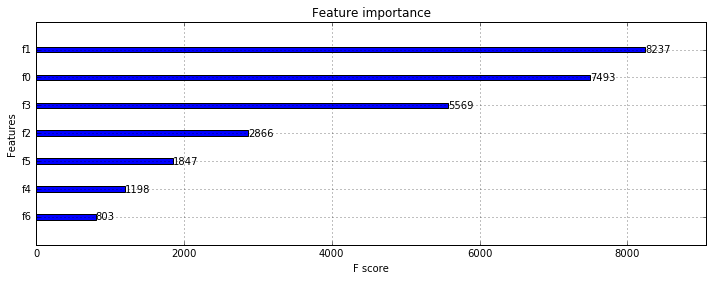

In [64]:
# lower learning rate and more iterations
er3 = {}
bst3 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.01,
                 'objective': 'multi:softprob',
                 'max_depth': 10}, 
                dtrain, 
                num_boost_round = 25,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er3,
                feval = map3eval)

plt.figure()
plt.plot(er3['test']['MAP@3'], 'r--', er3['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst3)

[0]	train-MAP@3:0.522529	test-MAP@3:0.489426
[1]	train-MAP@3:0.535274	test-MAP@3:0.492447
[2]	train-MAP@3:0.581308	test-MAP@3:0.537764
[3]	train-MAP@3:0.605265	test-MAP@3:0.555891
[4]	train-MAP@3:0.626924	test-MAP@3:0.564955
[5]	train-MAP@3:0.642315	test-MAP@3:0.570997
[6]	train-MAP@3:0.660631	test-MAP@3:0.586103
[7]	train-MAP@3:0.675813	test-MAP@3:0.595166
[8]	train-MAP@3:0.691622	test-MAP@3:0.601208
[9]	train-MAP@3:0.707152	test-MAP@3:0.60423
[10]	train-MAP@3:0.719758	test-MAP@3:0.613293
[11]	train-MAP@3:0.733686	test-MAP@3:0.616314
[12]	train-MAP@3:0.745665	test-MAP@3:0.622356
[13]	train-MAP@3:0.756181	test-MAP@3:0.628399
[14]	train-MAP@3:0.765583	test-MAP@3:0.63142
[15]	train-MAP@3:0.775054	test-MAP@3:0.637462
[16]	train-MAP@3:0.783133	test-MAP@3:0.640483
[17]	train-MAP@3:0.790166	test-MAP@3:0.643505
[18]	train-MAP@3:0.795877	test-MAP@3:0.640483
[19]	train-MAP@3:0.802215	test-MAP@3:0.649547
[20]	train-MAP@3:0.807368	test-MAP@3:0.649547
[21]	train-MAP@3:0.813357	test-MAP@3:0.652568


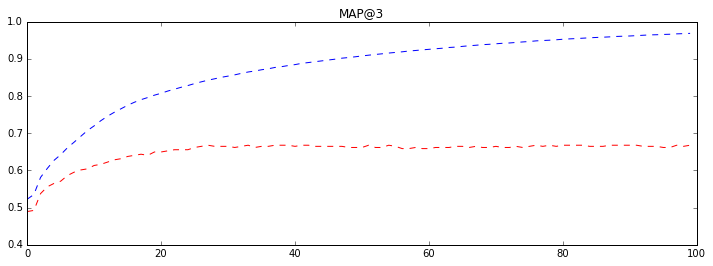

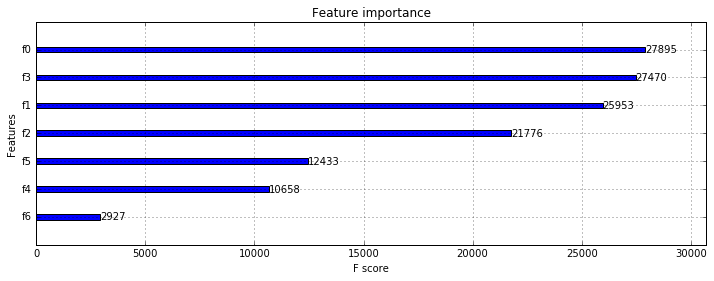

In [94]:
"""
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1
"""
# lower learning rate and more iterations
er4 = {}
bst4 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 5,
                 'min_child_weight': 1,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1}, 
                dtrain, 
                num_boost_round = 100,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er4,
                feval = map3eval)

plt.figure()
plt.plot(er4['test']['MAP@3'], 'r--', er4['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst4)

In [67]:
cv1 = xgb.cv({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.01,
                 'objective': 'multi:softprob',
                 'max_depth': 10}, 
                dtrain, 
                feval = map3eval, maximize = True, verbose_eval = True
        )

[0]	train-MAP@3:0.55133+0.00394978	test-MAP@3:0.527999+0.00310372
[1]	train-MAP@3:0.591238+0.00423461	test-MAP@3:0.566026+0.00111901
[2]	train-MAP@3:0.619132+0.0069521	test-MAP@3:0.591238+0.00461031
[3]	train-MAP@3:0.640305+0.00264835	test-MAP@3:0.610113+0.00209649
[4]	train-MAP@3:0.655001+0.00669573	test-MAP@3:0.621883+0.00265009
[5]	train-MAP@3:0.667119+0.00509258	test-MAP@3:0.6324+0.00239637
[6]	train-MAP@3:0.677741+0.00520685	test-MAP@3:0.641872+0.00350058
[7]	train-MAP@3:0.688676+0.00452247	test-MAP@3:0.649603+0.00325481
[8]	train-MAP@3:0.697834+0.00266248	test-MAP@3:0.65817+0.00291522
[9]	train-MAP@3:0.706749+0.00096877	test-MAP@3:0.664507+0.0034516


In [96]:
cv2 = xgb.cv({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 5,
                 'min_child_weight': 1,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1
              },
                dtrain, num_boost_round = 100, early_stopping_rounds = 20, 
                feval = map3eval, maximize = True, verbose_eval = True
        )

[0]	train-MAP@3:0.455495+0.00460841	test-MAP@3:0.435854+0.00447155
[1]	train-MAP@3:0.511353+0.0109989	test-MAP@3:0.485792+0.00547263
[2]	train-MAP@3:0.547987+0.0105796	test-MAP@3:0.514069+0.00495108
[3]	train-MAP@3:0.577935+0.0065459	test-MAP@3:0.537888+0.00258331
[4]	train-MAP@3:0.603183+0.00558864	test-MAP@3:0.556275+0.00214684
[5]	train-MAP@3:0.625644+0.00861049	test-MAP@3:0.573617+0.00433715
[6]	train-MAP@3:0.645842+0.0082092	test-MAP@3:0.58692+0.00532678
[7]	train-MAP@3:0.665727+0.0080627	test-MAP@3:0.601059+0.00469185
[8]	train-MAP@3:0.684183+0.00777507	test-MAP@3:0.612899+0.00307716
[9]	train-MAP@3:0.698983+0.00636285	test-MAP@3:0.624321+0.0021374
[10]	train-MAP@3:0.713087+0.00589581	test-MAP@3:0.632679+0.00240685
[11]	train-MAP@3:0.726006+0.00421503	test-MAP@3:0.641245+0.0016452
[12]	train-MAP@3:0.739344+0.002438	test-MAP@3:0.649742+0.00265021
[13]	train-MAP@3:0.751498+0.00306391	test-MAP@3:0.656637+0.00208455
[14]	train-MAP@3:0.763546+0.00247256	test-MAP@3:0.664298+0.00165697


In [89]:
from xgboost.sklearn import XGBClassifier
y1, enc1 = transform_y(card_train[:, 5])
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1)

xgb1.fit(X, y1, eval_set=[(X, y1)], eval_metric = 'merror')

In [123]:
best_map = 0
best_max_depth = 1
best_min_child_weight = 1
results1 = []
for max_depth in range(3, 10, 2):
    for min_child_weight in range(1, 6, 2):
        print "max_depth is %s" %(max_depth)
        print "min_child_weight is %s" %(min_child_weight)
        temp_cv = xgb.cv({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': max_depth,
                 'min_child_weight': min_child_weight,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1
              },
                dtrain, num_boost_round = 100, early_stopping_rounds = 20, 
                feval = map3eval, maximize = True
            )
        temp_map = temp_cv['test-MAP@3-mean'][temp_cv.shape[0]-1]
        results1.append([max_depth, min_child_weight, temp_map])
        print "map of current iteration is %s" %(temp_map)
        if temp_map > best_map:
            print "Best combination found and it is (max_depth: %s) and (min_child_weight: %s) with map@3: %s" %(max_depth, min_child_weight, temp_map)
            best_map = temp_map
            best_max_depth = max_depth
            best_min_child_weight = min_child_weight

print "~~~~~~~~~results~~~~~~~~~~~~~~~~"
print "best max depth is: %s" %(best_max_depth)
print "best min child weight is: %s" %(best_min_child_weight)
print "best_map", str(best_map)

max_depth is 3
min_child_weight is 1
map of current iteration is 0.613595
Best combination found and it is (max_depth: 3) and (min_child_weight: 1) with map@3: 0.613595
max_depth is 3
min_child_weight is 3
map of current iteration is 0.593954666667
max_depth is 3
min_child_weight is 5
map of current iteration is 0.617147333333
Best combination found and it is (max_depth: 3) and (min_child_weight: 5) with map@3: 0.617147333333
max_depth is 5
min_child_weight is 1
map of current iteration is 0.624321
Best combination found and it is (max_depth: 5) and (min_child_weight: 1) with map@3: 0.624321
max_depth is 5
min_child_weight is 3
map of current iteration is 0.612620333333
max_depth is 5
min_child_weight is 5
map of current iteration is 0.631076666667
Best combination found and it is (max_depth: 5) and (min_child_weight: 5) with map@3: 0.631076666667
max_depth is 7
min_child_weight is 1
map of current iteration is 0.626897666667
max_depth is 7
min_child_weight is 3
map of current iteratio

In [125]:
results1

[[3, 1, 0.613595],
 [3, 3, 0.59395466666666652],
 [3, 5, 0.61714733333333338],
 [5, 1, 0.62432100000000001],
 [5, 3, 0.61262033333333343],
 [5, 5, 0.63107666666666662],
 [7, 1, 0.62689766666666669],
 [7, 3, 0.61373433333333338],
 [7, 5, 0.63212166666666669],
 [9, 1, 0.62675866666666658],
 [9, 3, 0.61457033333333333],
 [9, 5, 0.63358400000000004]]

In [126]:
def transform_x1(X, x_transformer = None):
    """
    X = [[x, y, a, t]]
    """
    fw = [500., 1000., 4., 3., 2., 10., 10.]
    minute_v = X[:, 3]%60
    hour_v = X[:, 3]//60
    weekday_v = hour_v//24
    month_v = weekday_v//30
    year_v = (weekday_v//365 + 1)*fw[5]
    hour_v = ((hour_v%24 + 1) + minute_v/60.0)*fw[2]
    hour_v_2 = (X[:, 3]%(60*60*24))//(60*60*2)
    hour_v_3 = (X[:, 3]%(60*60*24))//(60*60*3)
    hour_v_4 = (X[:, 3]%(60*60*24))//(60*60*4)
    hour_v_6 = (X[:, 3]%(60*60*24))//(60*60*6)
    hour_v_8 = (X[:, 3]%(60*60*24))//(60*60*8)
    weekday_v = (weekday_v%7 + 1)*fw[3]
    month_v = (month_v%12 +1)*fw[4]
    accuracy_v = np.log10(X[:, 2])*fw[6]
    x_v = X[:, 0]*fw[0]
    y_v = X[:, 1]*fw[1]
    return np.hstack((x_v.reshape(-1, 1),
                     y_v.reshape(-1, 1),
                     accuracy_v.reshape(-1, 1),
                     hour_v.reshape(-1, 1),
                     hour_v_2.reshape(-1, 1),
                     hour_v_3.reshape(-1, 1),
                     hour_v_4.reshape(-1, 1),
                     hour_v_6.reshape(-1, 1),
                     hour_v_8.reshape(-1, 1),
                     weekday_v.reshape(-1, 1),
                     month_v.reshape(-1, 1),
                     year_v.reshape(-1, 1)))

X1 = transform_x1(card_train[:, (1, 2, 3, 4)])
y_orig, enc = transform_y(data[:, 5])
y, enc = transform_y(card_train[:, 5], enc)
test_X1 = transform_x1(test[:, (1, 2, 3, 4)])
test_y, enc = transform_y(test[:, 5], enc)
print X1.shape, "X shape"
print y.shape, "y shape"
print test_X1.shape, "test_X shape"
print test_y.shape, "test_y shape"
print len(enc['encoder'].classes_)

dtrain1 = xgb.DMatrix(X1, label=np.ravel(y))
dtest1 = xgb.DMatrix(test_X1, label=np.ravel(test_y))


(14359, 12) X shape
(14359, 1) y shape
(331, 12) test_X shape
(331, 1) test_y shape
770


In [ ]:
best_map = 0
best_max_depth = 1
best_min_child_weight = 1
results2 = []
for max_depth in range(7, 20, 2):
    for min_child_weight in range(5, 15, 2):
        print "max_depth is %s" %(max_depth)
        print "min_child_weight is %s" %(min_child_weight)
        temp_cv = xgb.cv({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': max_depth,
                 'min_child_weight': min_child_weight,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1
              },
                dtrain1, num_boost_round = 100, early_stopping_rounds = 20, 
                feval = map3eval, maximize = True
            )
        temp_map = temp_cv['test-MAP@3-mean'][temp_cv.shape[0]-1]
        results2.append([max_depth, min_child_weight, temp_map])
        print "map of current iteration is %s" %(temp_map)
        if temp_map > best_map:
            print "Best combination found and it is (max_depth: %s) and (min_child_weight: %s) with map@3: %s" %(max_depth, min_child_weight, temp_map)
            best_map = temp_map
            best_max_depth = max_depth
            best_min_child_weight = min_child_weight

print "~~~~~~~~~results~~~~~~~~~~~~~~~~"
print "best max depth is: %s" %(best_max_depth)
print "best min child weight is: %s" %(best_min_child_weight)
print "best_map", str(best_map)

max_depth is 7
min_child_weight is 5
map of current iteration is 0.761457
Best combination found and it is (max_depth: 7) and (min_child_weight: 5) with map@3: 0.761457
max_depth is 7
min_child_weight is 7
map of current iteration is 0.758322666667
max_depth is 7
min_child_weight is 9
map of current iteration is 0.752402666667
max_depth is 7
min_child_weight is 11
map of current iteration is 0.745368666667
max_depth is 7
min_child_weight is 13
map of current iteration is 0.737568
max_depth is 9
min_child_weight is 5
map of current iteration is 0.761944666667
Best combination found and it is (max_depth: 9) and (min_child_weight: 5) with map@3: 0.761944666667
max_depth is 9
min_child_weight is 7
map of current iteration is 0.758114333333
max_depth is 9
min_child_weight is 9
map of current iteration is 0.752611666667
max_depth is 9
min_child_weight is 11
map of current iteration is 0.745647
max_depth is 9
min_child_weight is 13
map of current iteration is 0.738125
max_depth is 11
min_chil